# SMS Spam Detection: Test & Visualization

이 노트북에서는
1. 전처리된 데이터(`train.csv`, `valid.csv`, `test.csv`)를 로드
2. 학습된 모델(`best_model_epoch*.pt`)을 불러와 테스트셋으로 성능 평가
3. Accuracy, Precision, Recall, F1-score 등 지표를 계산하여 저장
4. Confusion Matrix, ROC Curve, Precision-Recall Curve 등 다양한 시각화를 수행

**필요 라이브러리**  
- pandas  
- numpy  
- torch  
- transformers  
- matplotlib  
- seaborn  
- scikit-learn


## 셀 1: 라이브러리 및 경로 설정

In [28]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import torch

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm.auto import tqdm

In [50]:
os.chdir(os.path.abspath(".."))
PROJECT_ROOT = Path.cwd()  # 노트북을 프로젝트 루트에서 실행한다고 가정
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "processed")
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "checkpoints")

TRAIN_CSV = os.path.join(DATA_DIR, "train.csv")
VALID_CSV = os.path.join(DATA_DIR, "valid.csv")
TEST_CSV  = os.path.join(DATA_DIR, "test.csv")

# 모델 파일 이름 (가장 성능이 좋은 체크포인트)
BEST_MODEL_FILE = os.path.join(CHECKPOINT_DIR, "best_model_epoch1.pt")

# 디바이스 설정 (가능하면 GPU, 아니면 CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


## 셀 2: 데이터 로드 및 확인

In [51]:
# 1) CSV 파일 로드
train_df = pd.read_csv(TRAIN_CSV)
valid_df = pd.read_csv(VALID_CSV)
test_df  = pd.read_csv(TEST_CSV)

# 2) 간단히 데이터 크기와 상위 5개 확인
print("Train shape:", train_df.shape)
print(train_df.head(), "\n")

print("Valid shape:", valid_df.shape)
print(valid_df.head(), "\n")

print("Test shape:", test_df.shape)
print(test_df.head(), "\n")

# 3) 라벨 분포 살펴보기 (테스트셋)
print("Test set label distribution:")
print(test_df['label'].value_counts())

Train shape: (4459, 3)
  label                                               text  label_id
0   ham                   ok i am on the way to home hi hi         0
1  spam  ur balance is now 짙500. ur next question is: w...         1
2   ham  i'm tired of arguing with you about this week ...         0
3   ham      tell them the drug dealer's getting impatient         0
4   ham  hmmm... guess we can go 4 kb n power yoga... h...         0 

Valid shape: (557, 3)
  label                                               text  label_id
0   ham  the guy at the car shop who was flirting with ...         0
1   ham                sir goodmorning, once free call me.         0
2   ham                               i'm done. c 체 there.         0
3   ham                      o shore are you takin the bus         0
4   ham                    i will reach before ten morning         0 

Test shape: (558, 3)
  label                                               text  label_id
0   ham  good afternoon, my love 

## 셀 3: 텍스트 길이 분포 및 클래스 분포 시각화

In [52]:
for df, name in [(train_df, "Train"), (valid_df, "Valid"), (test_df, "Test")]:
    df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))

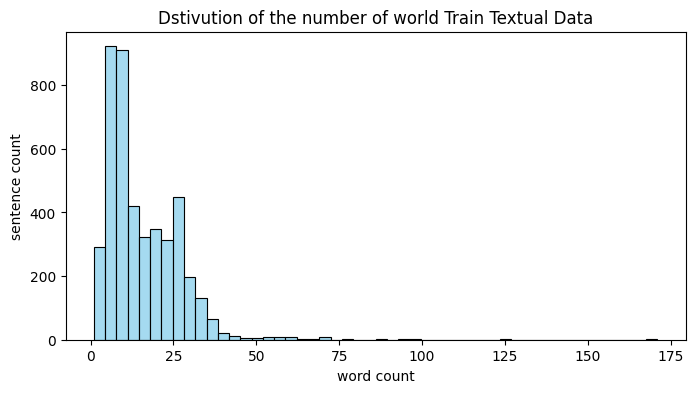

In [53]:
plt.figure(figsize=(8,4))
sns.histplot(train_df['text_length'], bins=50, kde=False, color="skyblue")
plt.title("Dstivution of the number of world Train Textual Data")
plt.xlabel("word count")
plt.ylabel("sentence count")
plt.show()

C:\Users\KIM DOHYUN\AppData\Local\Temp\ipykernel_4360\3733067825.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=test_df, palette=['lightgreen', 'salmon'])


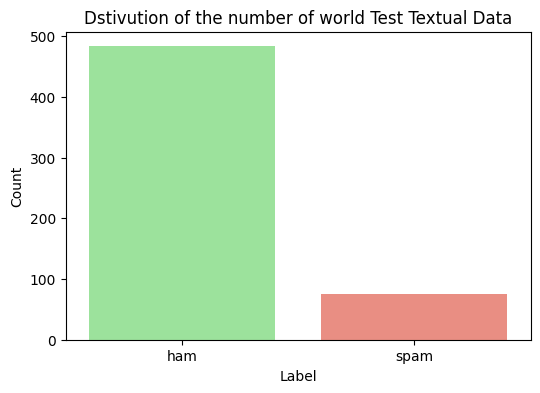

In [54]:
# 2) Test 클래스 분포 (ham/spam 비율)
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=test_df, palette=['lightgreen', 'salmon'])
plt.title("Dstivution of the number of world Test Textual Data")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

## 셀 4: PyTorch Dataset & DataLoader 정의

In [55]:
class SpamHamTestDataset(Dataset):
    """
    test.csv 로드 → 토크나이저를 사용하여 input_ids, attention_mask, label 반환
    """
    def __init__(self, csv_path, tokenizer_name="bert-base-uncased", max_length=128):
        self.df = pd.read_csv(csv_path)
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row['text'])
        label = int(row['label_id'])

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [56]:
test_dataset = SpamHamTestDataset(TEST_CSV, tokenizer_name="bert-base-uncased", max_length=128)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## 5: 학습된 모델 불러오기 / 테스트셋 평가

In [58]:
from src.model import SpamHamClassifier

model_name = "bert-base-uncased"
model = SpamHamClassifier(model_name=model_name, num_labels=2)
model.load_state_dict(torch.load(BEST_MODEL_FILE, map_location=device))
model.to(device)
model.eval()
print("Loaded model from:", BEST_MODEL_FILE)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded model from: C:\Users\KIM DOHYUN\Desktop\git\sms-spam-detection-classifier\checkpoints\best_model_epoch1.pt


In [59]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # shape: (batch_size, 2)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_probs.extend(probs.tolist())
        all_preds.extend(preds.tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

Testing:   0%|          | 0/18 [00:00<?, ?it/s]

In [60]:
# 1) Accuracy
acc = accuracy_score(all_labels, all_preds)

# 2) Precision, Recall, F1-score (binary)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')

print(f"Test Accuracy : {acc:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1-score      : {f1:.4f}")

Test Accuracy : 0.9946
Precision     : 0.9865
Recall        : 0.9733
F1-score      : 0.9799


## 6: Confusion Matrix 시각화

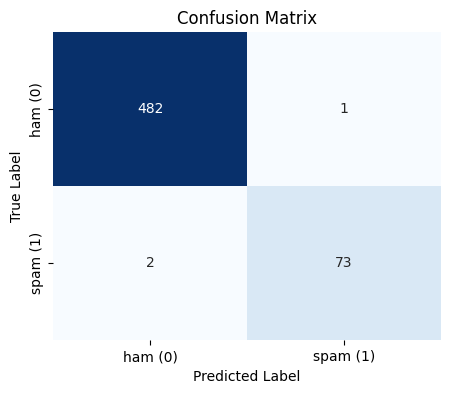

In [61]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["ham (0)", "spam (1)"],
            yticklabels=["ham (0)", "spam (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## 7: ROC Curve 및 AUC

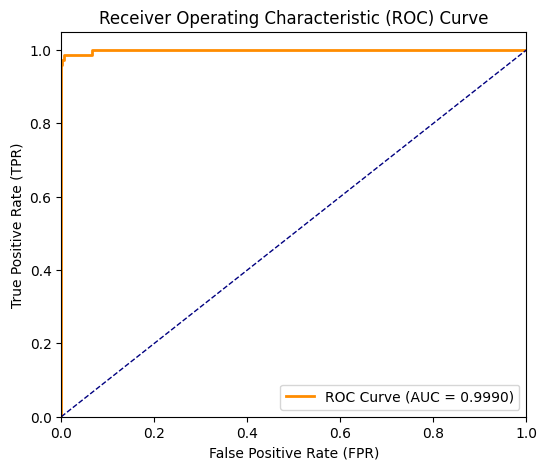

In [62]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0,1], [0,1], color="navy", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

## 8: Precision-Recall Curve

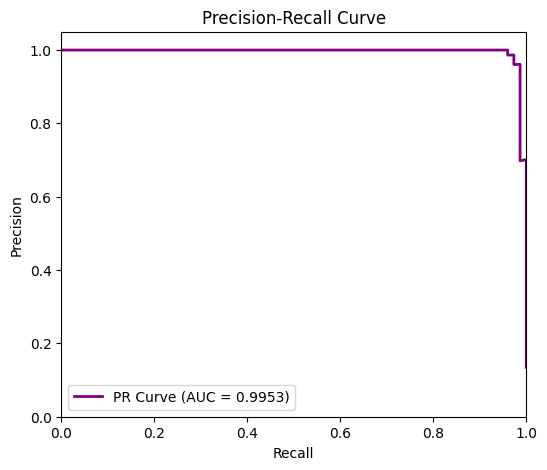

In [64]:
precision_points, recall_points, pr_thresholds = precision_recall_curve(all_labels, all_probs)
pr_auc = auc(recall_points, precision_points)

plt.figure(figsize=(6,5))
plt.plot(recall_points, precision_points, color="purple", lw=2, label=f"PR Curve (AUC = {pr_auc:.4f})")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

## 9: 잘못 예측된 샘플(오분류) 확인

In [65]:
# 테스트셋 원본과 예측 결과를 하나의 DataFrame에 합치기
test_df['pred_label'] = all_preds
test_df['prob_spam'] = all_probs

# 오분류된 샘플 필터링
wrong_df = test_df[test_df['label_id'] != test_df['pred_label']].copy()
print("오분류 샘플 개수:", len(wrong_df))
display(wrong_df.head(10))

오분류 샘플 개수: 3


,label,text,label_id,text_length,pred_label,prob_spam
215,ham,staff.science.nus.edu.sg/~phyhcmk/teaching/pc1323,0,1,1,0.907221
334,spam,for sale - arsenal dartboard. good condition b...,1,12,0,0.107449
515,spam,romcapspam everyone around should be respondin...,1,26,0,0.006788


## 마무리

- **Test Performance Metrics**: Accuracy, Precision, Recall, F1, ROC AUC, PR AUC 등을 DataFrame으로 정리하고 파일로 저장했습니다.
- **시각화**: Confusion Matrix, ROC Curve, Precision-Recall Curve 등을 그려보았습니다.
- **오분류 사례**: 실제로 모델이 잘못 예측한 샘플들을 살펴보며, 데이터 및 모델 개선 포인트를 찾을 수 있습니다